In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

In [2]:
data_source_url = "Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)

In [3]:
#show data overview
airline_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
plot_size = plt.rcParams["figure.figsize"]
print(plot_size[0])
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

6.0
4.0


<AxesSubplot:ylabel='airline'>

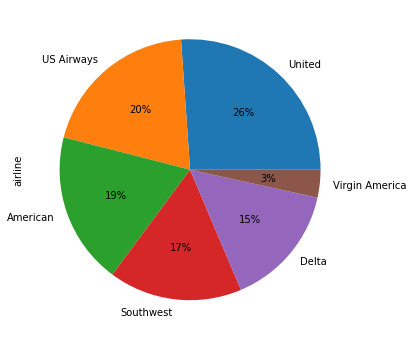

In [5]:
airline_tweets.airline.value_counts().plot(kind='pie',autopct='%1.0f%%')

<AxesSubplot:ylabel='airline_sentiment'>

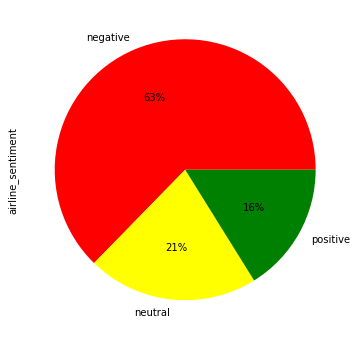

In [6]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie',autopct='%1.0f%%',colors=["red","yellow","green"])

<AxesSubplot:xlabel='airline'>

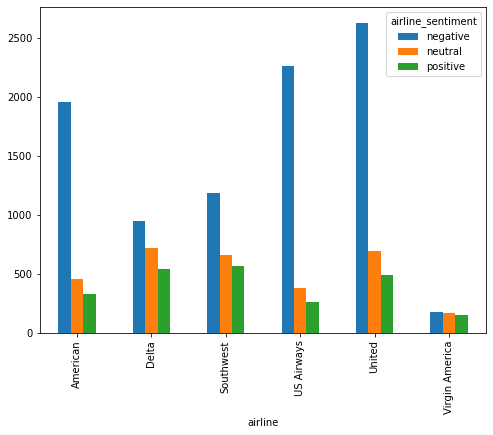

In [7]:
#without unstack(), columns with same airlines would not be grouped
airline_sentiment=airline_tweets.groupby(['airline','airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

<AxesSubplot:xlabel='airline_sentiment', ylabel='airline_sentiment_confidence'>

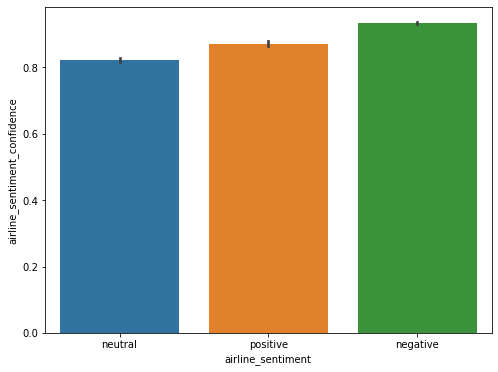

In [8]:
import seaborn as sns
sns.barplot(x='airline_sentiment',y='airline_sentiment_confidence',data=airline_tweets)

In [9]:
features = airline_tweets.iloc[:,10].values #text column
labels = airline_tweets.iloc[:,1].values #airline_sentiment column

Some regex has been modified below, some useful characters include:

* \D: non-digit characters
* ^: the beginning of a line
* \\$: end of a line

The three regexes on removing single characters could be combined into one expression such as:

```regex
(\s\D\s)|\^(\D\s)|(\s\D)\$
```

In [10]:
processed_features = []

for sentence in range(0, len(features)):
    
    #Remove all special characters
    processed_feature = re.sub(r'\W',' ',str(features[sentence]))
    
    #Remove all single characters in the middle of the sentence, start of sentence, and end of sentence
    # \D: non-digit characters      
    processed_feature = re.sub(r'(\s\D\s)',' ',processed_feature)
    
    # Remove single characters from the start
    # ^: start of line  
    processed_feature = re.sub(r'^(\D\s)', ' ', processed_feature) 
    
    # Remove single characters from the end (for clarity, this and the previous 2 regexes have been separated)
    # $: end of line
    processed_feature = re.sub(r'(\s\D)$', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

For this next step, an option is to download the stopwords per run. Alternatively, a copy of the stopwords can be downloaded once for future importing using [this article](https://medium.com/@satorulogic/how-to-manually-download-a-nltk-corpus-f01569861da9)

Not having a copy of the stopwords beforehand causes an error.

In [11]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer



In [12]:
vectorizer = TfidfVectorizer (max_features = 2500, min_df=7, max_df=0.8, stop_words = stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size = 0.2, random_state = 0)

In [14]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [15]:
predictions = text_classifier.predict(X_test)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[1723  108   39]
 [ 326  248   40]
 [ 132   58  254]]
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.60      0.40      0.48       614
    positive       0.76      0.57      0.65       444

    accuracy                           0.76      2928
   macro avg       0.72      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928

0.7599043715846995
